In [ ]:
from google.colab import drive
import sys
import os
from IPython import display
drive.mount('/content/drive')
FOLDERNAME = 'models_from_scratch'

sys.path.append('/contente/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/models_from_scratch


## GoogLeNet(InceptionNet)
"We need to go deeper" (2010, inception) <br>
의의: 효율적이면서 성능이 뛰어난 deep learning model 개발 시발점

paper: https://arxiv.org/abs/1409.4842 <br>
ref(how to make GoogLeNet with PyTorch, youtuber: Aladdin Persson): <br>
https://www.youtube.com/watch?v=uQc4Fs7yx5I&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=18 <br>
(GoogLeNet 설명(한글)) <br>
https://phil-baek.tistory.com/entry/3-GoogLeNet-Going-deeper-with-convolutions-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0 <br>
(Auxiliary classifiers) <br>
http://datacrew.tech/inception-v1-2014/

탄생배경 <br>
conv net의 성능을 올리는 일반적인 방법은 2가지가 있습니다. <br>
> 1) increase the depth(level) <br>
> 2) increase the width(각 level의 unit) <br>

해당 방법들의 문제점 <br>
> 1) overfitting(과적합) <br>
> 2) 급격히 증가하는 computational resources <br>
* overfitting: 모델이 train data에 overfitting하여 test data에 대해서 낮은 성능을 보이는 case <br>
사람에게 비유하면 한 학생이 책에 있는 문제를 모두 외워서 책에 있는 문제는 잘 풀지만 처음 보는 문제(시험)에서는 낮은 점수를 받는 것과 비슷한 경우<br>
(적절한 학습이 이루어지지 않았다는 반증)

위의 문제를 근본적으로 풀기 위해서는 fully connected layer에서 sparsely connected layer로 변환하면 된다. <br>
하지만, computer 구조상 non-uniform sparsely data를 다루는 데에 비효율적이므로 이를 적용하기 어려움. <br>

sparse 매트릭스를 clustering(묶어서), 상대적으로 dense한 submatricies로 변환하여 계산하는 것이 sparse matrix 연산 논문에서 좋은 성능을 보이는 것이 입증되어왔음. <br>

해당 아이디어를 따와서 conv net에 적용 <br>

ref: https://phil-baek.tistory.com/entry/3-GoogLeNet-Going-deeper-with-convolutions-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0

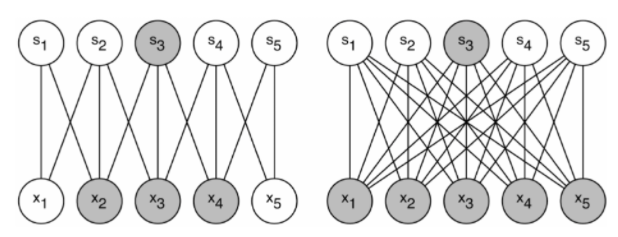

In [ ]:
from IPython import display
# from https://phil-baek.tistory.com/entry/3-GoogLeNet-Going-deeper-with-convolutions-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0
display.Image('https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FBGbXV%2FbtqSDvAa5N1%2FbVaRLW8gpuO5ymxKZfHkbK%2Fimg.png')

# 왼쪽 sparse matrix, 오른쪽 dense matrix

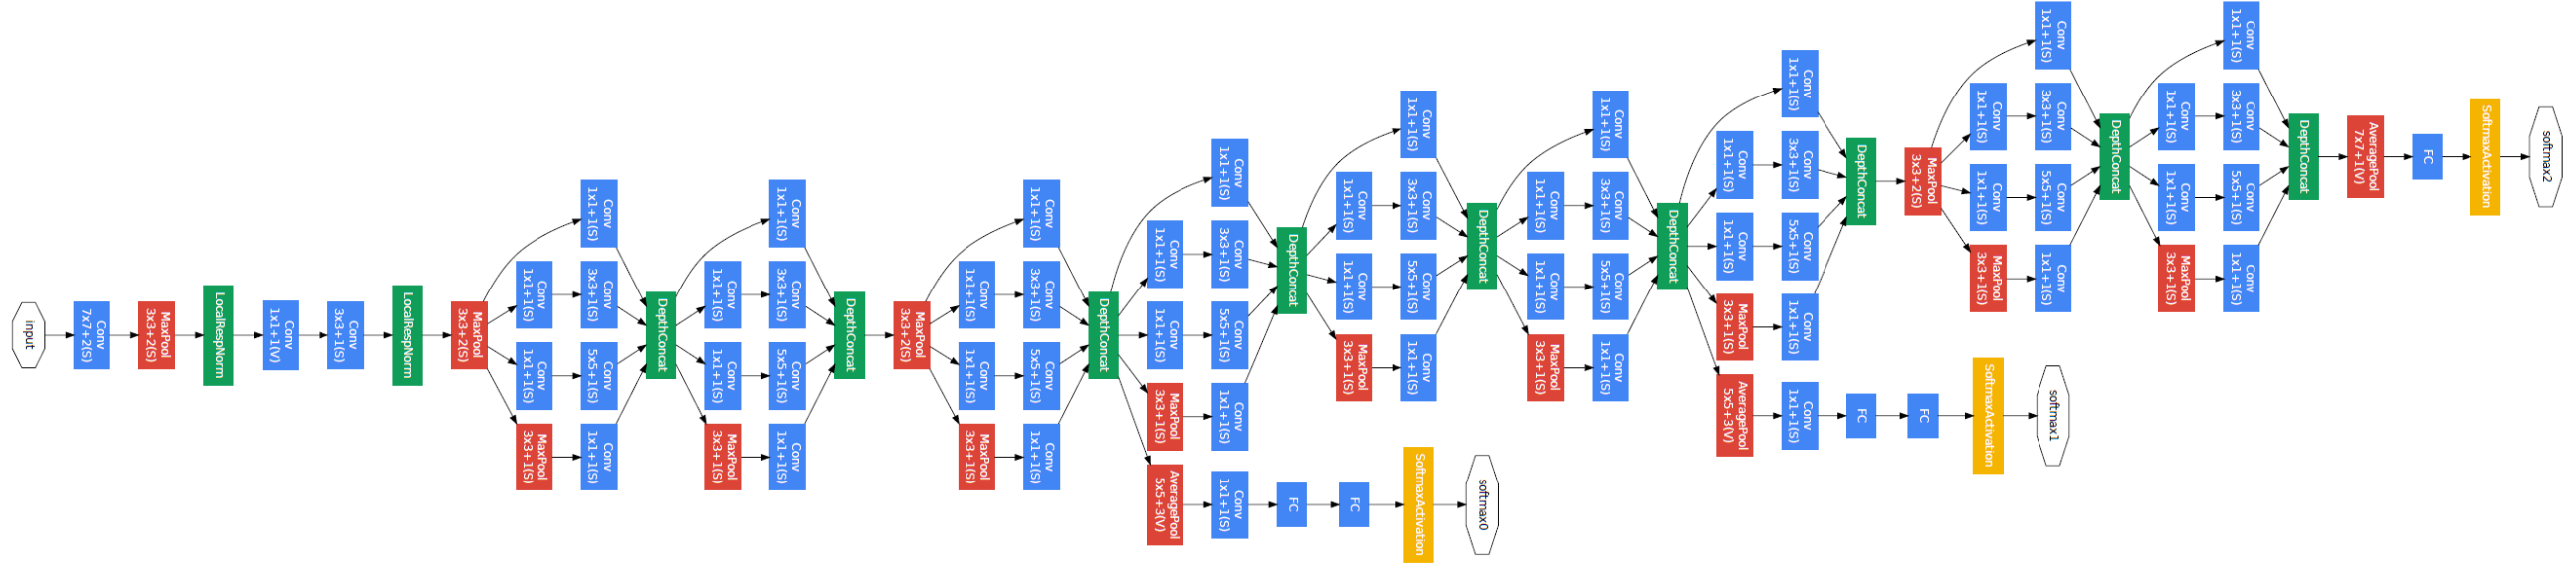

In [ ]:
# GoogLeNet architecture
display.Image('https://blog.kakaocdn.net/dn/Iq9NO/btqyPWk5PBX/K2JicGjIjj5w0eFIbhx4bK/img.png')

GoogLeNet의 전체 구조는 inception module이라 불리는 block이 반복되어 layer를 쌓아나가는 구조입니다.

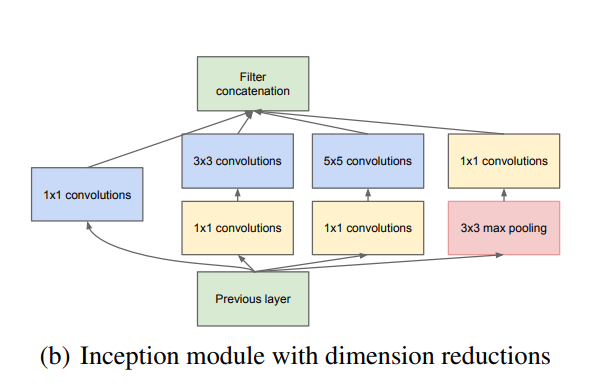

In [ ]:
# inception module from paper Figure 2. (b)
display.Image(os.path.join(os.getcwd(), 'pic/inception_module.png'))

그러면 psudo code로 Inception module을 만들어 보겠습니다. <br>
```python
class inception_module(nn.Module):
  def __init__(self):
    self.conv1 = nn.Conv2d(in_channels,
                          out_channels,
                          kernel_size = (1, 1),
                          stride = 1) # 가장 왼쪽 conv net

    self.conv_3x3 = nn.Sequential(nn.Conv2d(kernel_size = (1, 1),
                                            stride = 1),
                                  nn.Conv2d(kernel_size = (3, 3),
                                            stride = 1,
                                            padding = 1))
    
    self.conv_5x5 = nn.Sequential(nn.Conv2d(kernel_size = (1, 1),
                                            stride= 1,),
                                  nn.Conv2d(kernel_size = (5, 5),
                                            stride =1,
                                            padding = 2)

    self.projection = nn.Sequential(nn.MaxPool2d(),
                                    nn.Conv2d(in_channels,
                                              out_channels,
                                              kernel_size = (1, 1),
                                              stride = 1) # 가장 오른쪽 layer
  def forward(self, x):
    out1 = self.conv1(x)
    out2 = self.conv_3x3(x)
    ...
    return concat(outs, dim = filter)

```

위의 GoogLeNet architecture image를 자세히 보시면 중간에 튀어나온 module을 확인하실 수 있습니다. <br>
해당 module은 깊이가 매우 깊어지는 architecture의 경우 gradient vanishing/exploding이 발생하여 model의 성능을 떨어뜨릴 수 있기 때문에 중간마다 역전파를 계속 전달해주는 역할을 합니다. <br>
단, test 시에는 해당 모듈을 사용하지 않고 output을 도출합니다.

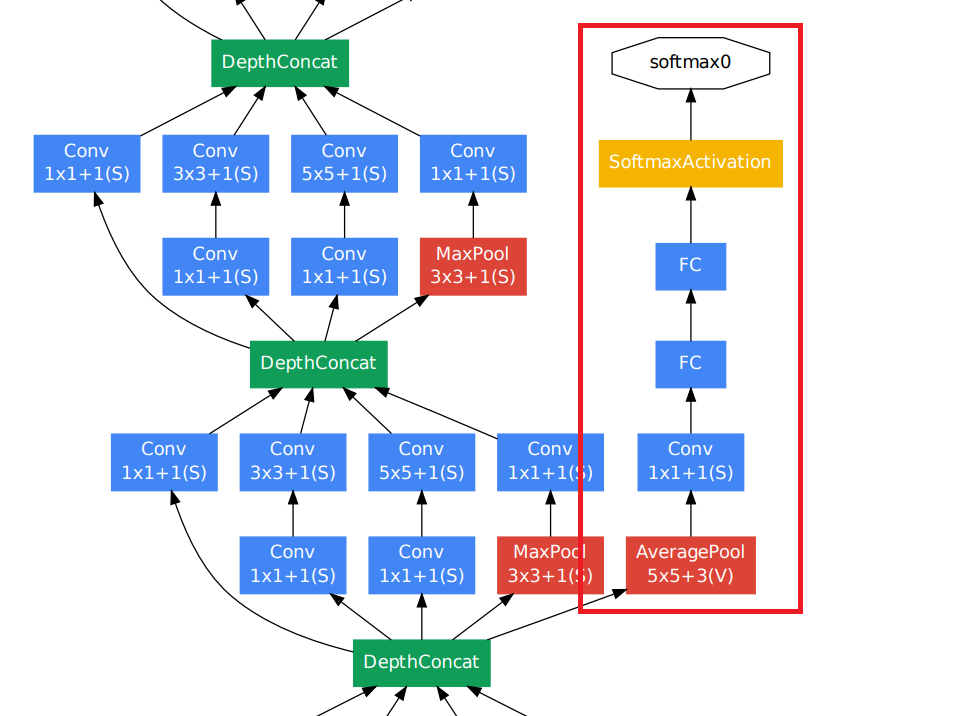

In [ ]:
# from paper Figure 3.
display.Image(os.path.join(os.getcwd(), 'pic/auxiliary_classifier.png'), height = 300)

```python
# psudo code
class auxiliary_classifier(nn.Module):
  def __init__(self):
    self.auxiliary_classifier = nn.Sequential(nn.AvgPool2d(),
                                            nn.Conv2d(kernel_size = (1,1),
                                                      stride = 1),
                                            nn.Linear(),
                                            nn.Linear(),
                                            nn.Softmax())

  def forward(self, x)
    return self.auxiliary_classifier(x)
```

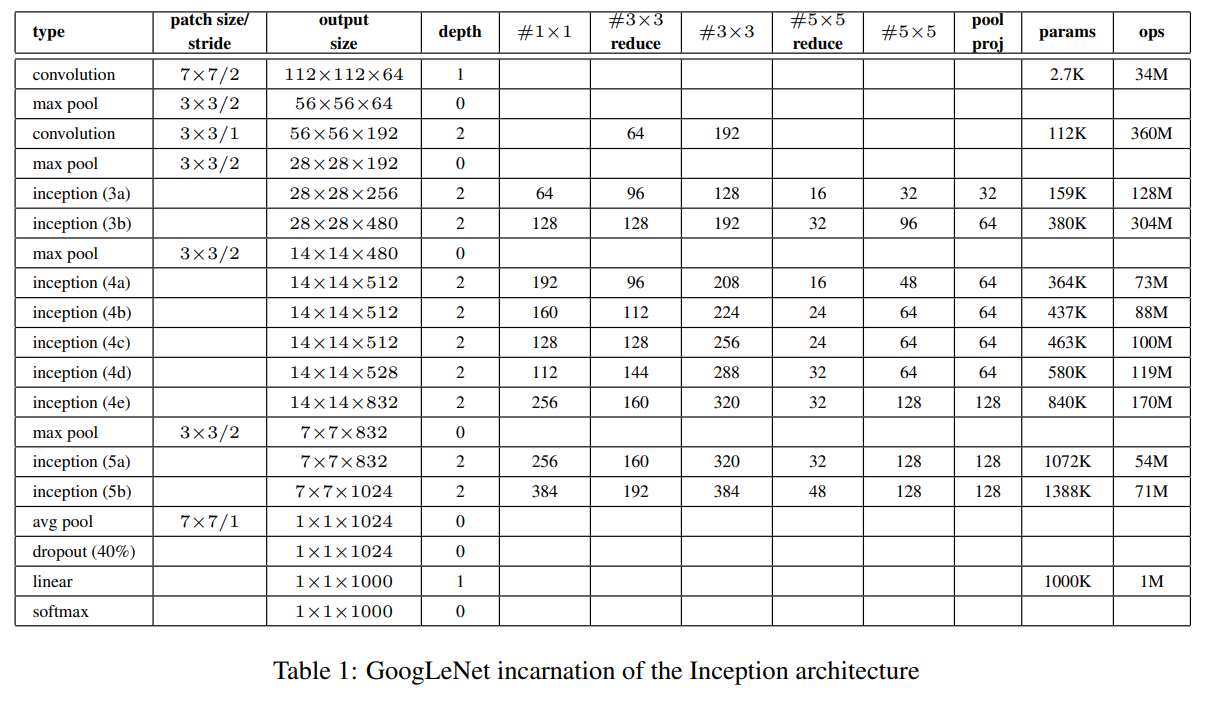

In [ ]:
# GoogLeNet architecture table from paper table 1
display.Image(os.path.join(os.getcwd(), 'pic/GoogLeNet.png'), height = 450)

```python
#psudo code
class GoogLeNet(nn.Module):
  def __init__():
    self.conv = nn.Conv2d()
    self.pool = nn.MaxPool2d()
    self.inception_3a = inception_module()
    ...
    self.classifier_1 = auxiliary_classifier()
    self.classifier_2 = auxiliary_classifier()
    ...

    self.fc = nn.Sequential(nn.AvgPool2d(),
                            nn.DropOut(),
                            nn.Flatten(),
                            nn.Linear(),
                            nn.Softmax())

  def forward(self, x)
    out_1 = self.classifier_1(blocks(x))
    out_2 = self.classifier_2(blocks(x))
    out_3 = self.fc(blocks(x))
    
    return out_1, out_2, out_3
```

## Let's make GoogLeNet
순서 <br>
1) inception module <br>
2) auxiliary_classifier <br>
3) GoogLeNet

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class inception_module(nn.Module):
  def __init__(self, 
               in_channels, 
               reduce_3_out, 
               reduce_5_out, 
               conv_1_out, 
               conv_3_out, 
               conv_5_out, 
               proj_out):
    super(inception_module, self).__init__()
    self.reduce_3 = nn.Conv2d(in_channels = in_channels,
                         out_channels = reduce_3_out,
                         kernel_size = (1, 1),
                         stride = 1)
    self.conv_3 = nn.Conv2d(in_channels = reduce_3_out,
                       out_channels = conv_3_out,
                       kernel_size = (3, 3),
                       stride = 1,
                       padding = 1)
    
    self.reduce_5 = nn.Conv2d(in_channels = in_channels,
                         out_channels = reduce_5_out,
                         kernel_size = (1, 1),
                         stride = 1)
    self.conv_5 = nn.Conv2d(in_channels = reduce_5_out,
                       out_channels = conv_5_out,
                       kernel_size =(5, 5),
                       stride = 1,
                       padding = 2)
    
    self.pool = nn.MaxPool2d(kernel_size = (3, 3),
                             stride = (1, 1),
                             padding = 1)
    
    self.proj = nn.Conv2d(in_channels = in_channels,
                            out_channels = proj_out,
                            kernel_size = (1, 1),
                            stride = 1)
    self.conv_1 = nn.Conv2d(in_channels = in_channels,
                          out_channels = conv_1_out,
                          kernel_size = (1, 1),
                          stride = 1)
                            
  def forward(self, x):
    '''
    inputs:
      - previous layer(Tensor[N, in_channels, H, W])
    returns:
      - filter concat(Tensor[N, concat(channels), H, W])
    * channels: (conv_1_out, conv_3_out, conv_5_out, proj_out)
    '''
    output_1 = self.conv_1(x)
    output_2 = self.conv_3(self.reduce_3(x))
    output_3 = self.conv_5(self.reduce_5(x))
    output_4 = self.proj(self.pool(x))

    return torch.cat((output_1, output_2, output_3, output_4), 1)

In [ ]:
X = torch.randn(1, 192, 28, 28)
model = inception_module(in_channels = 192,
                         reduce_3_out = 96,
                         reduce_5_out = 16,
                         conv_1_out = 64,
                         conv_3_out = 128,
                         conv_5_out = 32,
                         proj_out = 32)

In [ ]:
output = model(X)
output.size()

torch.Size([1, 256, 28, 28])

In [ ]:
# after 4a, 4d
# after avg pool2d 4a -> (4, 4, 512), 4d -> (4, 4, 528) from paper page 6 bottom line 
# ref(stride, out_channels, ..., etc): http://datacrew.tech/inception-v1-2014/
class auxiliary_classifier(nn.Module): 
  def __init__(self, in_channels, num_classes):
    super(auxiliary_classifier, self).__init__()
    self.auxiliary_classifier = nn.Sequential(nn.AvgPool2d(kernel_size = (5, 5),
                                                           stride = 3),
                                            nn.Conv2d(in_channels= in_channels,
                                                      out_channels = 128,
                                                      kernel_size = (1,1),
                                                      stride = 1),
                                            nn.Flatten(),
                                            nn.Linear(in_features = 128 * 4 * 4,
                                                      out_features = 1024),
                                            nn.Linear(in_features = 1024, 
                                                      out_features = num_classes),
                                            nn.Softmax(dim = -1))

  def forward(self, x):
    return self.auxiliary_classifier(x)

In [ ]:
# batch norm, activation fn, ... 생략
class GoogLeNet(nn.Module):
  def __init__(self, img_channels = 3, num_classes = 1000):
    super(GoogLeNet, self).__init__()
    self.prev_inception = nn.Sequential(
        nn.Conv2d(in_channels = img_channels,
                  out_channels = 64,
                  kernel_size = (7, 7),
                  stride = 2,
                  padding = 3),
        nn.MaxPool2d(kernel_size = (3, 3),
                     stride = 2,
                     padding = 1),
        nn.Conv2d(in_channels = 64,
                  out_channels = 192,
                  kernel_size =(3, 3),
                  stride = 1,
                  padding = 1),
        nn.MaxPool2d(kernel_size = (3, 3),
                     stride= 2,
                     padding = 1)
    )
    self.inception_3a = inception_module(in_channels = 192,
                         reduce_3_out = 96,
                         reduce_5_out = 16,
                         conv_1_out = 64,
                         conv_3_out = 128,
                         conv_5_out = 32,
                         proj_out = 32)
    self.inception_3b = inception_module(in_channels = 256,
                         reduce_3_out = 128,
                         reduce_5_out = 32,
                         conv_1_out = 128,
                         conv_3_out = 192,
                         conv_5_out = 96,
                         proj_out = 64)
    self.pool_3 = nn.MaxPool2d(kernel_size = (3, 3),
                             stride = 2,
                             padding = 1)
    
    self.inception_4a = inception_module(in_channels = 480,
                         reduce_3_out = 96,
                         reduce_5_out = 16,
                         conv_1_out = 192,
                         conv_3_out = 208,
                         conv_5_out = 48,
                         proj_out = 64)
    self.classifier_1 =  auxiliary_classifier(in_channels = 512,
                                              num_classes = num_classes)

    self.inception_4b = inception_module(in_channels = 512,
                         reduce_3_out = 112,
                         reduce_5_out = 24,
                         conv_1_out = 160,
                         conv_3_out = 224,
                         conv_5_out = 64,
                         proj_out = 64)
    self.inception_4c = inception_module(in_channels = 512,
                         reduce_3_out = 128,
                         reduce_5_out = 24,
                         conv_1_out = 128,
                         conv_3_out = 256,
                         conv_5_out = 64,
                         proj_out = 64)
    self.inception_4d = inception_module(in_channels = 512,
                         reduce_3_out = 144,
                         reduce_5_out = 32,
                         conv_1_out = 112,
                         conv_3_out = 288,
                         conv_5_out = 64,
                         proj_out = 64)
    self.classifier_2 =  auxiliary_classifier(in_channels = 528,
                                              num_classes = num_classes)

    self.inception_4e = inception_module(in_channels = 528,
                         reduce_3_out = 160,
                         reduce_5_out = 32,
                         conv_1_out = 256,
                         conv_3_out = 320,
                         conv_5_out = 128,
                         proj_out = 128)
    self.pool_4 = nn.MaxPool2d(kernel_size = (3, 3),
                             stride = 2,
                             padding = 1)
    
    self.inception_5a = inception_module(in_channels = 832,
                         reduce_3_out = 160,
                         reduce_5_out = 32,
                         conv_1_out = 256,
                         conv_3_out = 320,
                         conv_5_out = 128,
                         proj_out = 128)
    self.inception_5b = inception_module(in_channels = 832,
                         reduce_3_out = 192,
                         reduce_5_out = 48,
                         conv_1_out = 384,
                         conv_3_out = 384,
                         conv_5_out = 128,
                         proj_out = 128)
    self.pool_5 = nn.AdaptiveAvgPool2d((1, 1))
    self.drop = nn.Dropout(p=0.4)
    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 1024,
                  out_features = num_classes),
        nn.Softmax(dim = -1)

    )
  def forward(self, x):
    x = self.prev_inception(x)
    print(x.size())
    x = self.inception_3a(x)
    print(x.size())
    x = self.inception_3b(x)
    print(x.size())
    x = self.pool_3(x)
    
    x = self.inception_4a(x)
    print(x.size())
    out_1 = self.classifier_1(x)
    
    x = self.inception_4b(x)
    print(x.size())
    x = self.inception_4c(x)
    print(x.size())
    x = self.inception_4d(x)
    print(x.size())
    out_2 = self.classifier_2(x)

    x = self.inception_4e(x)
    print(x.size())
    x = self.pool_4(x)

    x = self.inception_5a(x)
    print(x.size())
    x = self.inception_5b(x)
    print(x.size())
    x = self.pool_5(x)
    x = self.drop(x)
    x = self.fc(x)
    print(x.size())
    return out_1, out_2, x
    

In [ ]:
model = GoogLeNet()
x = torch.randn(1, 3, 224, 224)

In [ ]:
out_1, out_2, out = model(x)

torch.Size([1, 192, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 480, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 528, 14, 14])
torch.Size([1, 832, 14, 14])
torch.Size([1, 832, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1000])


In [ ]:
# 학습이 전혀 이루어지지 않았으므로 결과값이 비슷한 확률을 지니는 것을 확인할 수 있습니다.
out[0, 0:30] 

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010], grad_fn=<SliceBackward0>)

In [ ]:
print('out_1 size: ', out_1.size())
print('out_2 size: ', out_2.size())
print('out size: ', out.size())

out_1 size:  torch.Size([1, 1000])
out_2 size:  torch.Size([1, 1000])
out size:  torch.Size([1, 1000])


In [ ]:
# model parameter 개수
count = 0
for param in model.parameters():
  count += param.numel()
print(count)

13374120
